# Causal Inference on Customer Satisfaction Data

This project uses causal inference methods to measure the effect of perceived product quality on customer loyalty. Data are from the paper: [The American Customer Satisfaction Index (ACSI): A sample dataset and description](https://www.sciencedirect.com/science/article/pii/S2352340923002421).

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from dowhy import CausalModel
pd.set_option('display.max_columns', None)

## Load Data

This project uses publicly available data from https://data.mendeley.com/datasets/64xkbj2ry5/2.

In [2]:
url = 'https://data.mendeley.com/public-files/datasets/64xkbj2ry5/files/e4e4b8b0-0d7d-41a9-a2be-c1e586897d7e/file_downloaded'
response = requests.get(url)

if response.status_code == 200:
    xls = pd.ExcelFile(BytesIO(response.content))
    df = pd.read_excel(xls, sheet_name=0)
    readme = pd.read_excel(xls, sheet_name=1)
    print("Data loaded successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

Data loaded successfully.


Make the columns lowercase for ease of access.

In [3]:
df.columns = df.columns.str.lower()

## Explore Data

Check the number of rows and columns in the data. It contains several thousand records.

In [4]:
df.shape

Take a look at the dataset. Fields appear to be numeric, and there are some missing values.

In [5]:
df.head(3)

,industry,year,satis,confirm,ideal,overallx,customx,wrongx,overallq,customq,wrongq,pq,qp,comp,handle,repur,highptol,lowptol,age,educat,hispanic,race_1,race_2,race_3,race_4,race_5,income,gender,zipcode
0,3003,2015,9,8,8,10.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0,NaN,9.0,98.0,NaN,67,4.0,0.0,1.0,NaN,NaN,NaN,NaN,7.0,1.0,25177.0
1,3003,2015,8,6,7,8.0,8.0,8.0,8.0,8.0,9.0,8.0,8.0,0.0,NaN,8.0,5.0,NaN,32,4.0,0.0,1.0,NaN,NaN,NaN,NaN,1.0,2.0,2474.0
2,3003,2015,8,8,9,9.0,8.0,8.0,9.0,9.0,9.0,4.0,4.0,0.0,NaN,9.0,15.0,NaN,49,4.0,0.0,1.0,NaN,NaN,NaN,NaN,99.0,2.0,48374.0


In [6]:
df.describe()

,industry,year,satis,confirm,ideal,overallx,customx,wrongx,overallq,customq,wrongq,pq,qp,comp,handle,repur,highptol,lowptol,age,educat,hispanic,race_1,race_2,race_3,race_4,race_5,income,gender,zipcode
count,8239.000000,8239.0,8239.000000,8239.000000,8239.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,1393.000000,8071.000000,6543.000000,1284.000000,8239.000000,8169.000000,8169.000000,8169.000000,170.000000,28.000000,7.000000,4.00000,8169.000000,8169.000000,8093.000000
mean,3135.045637,2015.0,7.889550,7.522758,7.980216,10.120927,9.247801,9.460909,8.539214,8.496964,8.686408,8.546153,8.673770,1.498451,7.768126,10.523107,36.557390,45.436916,43.603107,3.765700,0.981026,2.404946,3.347059,4.107143,4.857143,5.50000,10.970253,1.751622,48363.955394
std,1467.636420,0.0,3.368115,6.940715,8.999729,12.891666,9.545329,12.707867,6.600114,6.643923,9.509803,10.373344,9.942649,11.318580,11.834227,15.638661,37.528178,36.332833,15.072497,4.179194,9.416589,10.335404,1.147479,1.165532,1.069045,0.57735,23.908309,3.913597,30255.816673
min,1001.000000,2015.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,18.000000,1.000000,0.000000,1.000000,2.000000,3.000000,4.000000,5.00000,1.000000,1.000000,1001.000000
25%,3003.000000,2015.0,7.000000,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,0.000000,4.000000,7.000000,10.000000,25.000000,31.000000,3.000000,0.000000,1.000000,2.000000,3.000000,4.000000,5.00000,3.000000,1.000000,21078.000000
50%,3013.000000,2015.0,8.000000,7.000000,8.000000,9.000000,9.000000,9.000000,8.000000,9.000000,9.000000,8.000000,8.000000,0.000000,7.000000,9.000000,25.000000,26.000000,42.000000,4.000000,0.000000,1.000000,3.000000,4.000000,4.000000,5.50000,5.000000,2.000000,45040.000000
75%,5001.000000,2015.0,10.000000,9.000000,9.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,0.000000,9.000000,10.000000,98.000000,98.000000,55.000000,4.000000,0.000000,1.000000,4.000000,5.000000,6.000000,6.00000,7.000000,2.000000,77021.000000
max,5001.000000,2015.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,101.000000,101.000000,90.000000,99.000000,99.000000,99.000000,6.000000,6.000000,6.000000,6.00000,99.000000,99.000000,99801.000000


Review the README. Key features that we will use in analysis have the following definitions in the original [paper](https://www.sciencedirect.com/science/article/pii/S2352340923002421):
- <b>industry:</b> 1001=“Processed Food (Nondurables)”; 3003=“Commercial Airlines (Transportation)”; 3013=“Internet Service Providers (Telecommunications)”; and 5001=“Commercial Banks (Finance).”

- <b>overallq:</b> How high has the overall quality of the product/service actually been? (Not very high—Very high).

- <b>repur:</b> The next time you seek to buy a new product/service, how likely is it you will buy the same
brand again? (Not very likely—Very likely)

- <b>overallx:</b> How high did you expect the overall quality of the product/service to be? (Not very high—Very high).

- <b>pq:</b> Given the quality of the product/service, how would you rate the price you paid? (Not very good—Very good).

- <b>satis:</b> Considering all of your experiences to date with the company/brand, how satisfied are you?
(Very dissatisfied—Very satisfied).

- <b>comp:</b> Have you complained about your product/service to the company within the past six
months? (Yes—No).

In [7]:
readme

,VARIABLE,LABEL,VALUE,Missing Data Coded As:
0,INDUSTRY,Industry Code,"1001=""Processed Food (Nondurables); 3003=""Comm...","98,99"
1,YEAR,Year in which data collected,Year,"98,99"
2,SATIS,Overall Customer Satisfaction,"1=""Very dissatisfied""; 10=""Very satisfied""","98,99"
3,CONFIRM,Confirmation to Expectations,"1=""Falls short of expectations""; 10=""Exceeds e...","98,99"
4,IDEAL,Close to ideal product/service,"1=""Not very close to ideal""; 10=""Very close to...","98,99"
5,OVERALLX,Expectation about overall quality,"1=""Not very high""; 10=""Very high""","98,99"
6,CUSTOMX,Expectations about customization,"1=""Not very high""; 10=""Very high""","98,99"
7,WRONGX,Expectation about reliability,"1=""Not very high""; 10=""Very high""","98,99"
8,OVERALLQ,Overall Quality,"1=""Not very good""; 10=""Very good""","98,99"
9,CUSTOMQ,Meeting personal requirement (Customization),"1=""Not very good""; 10=""Very good""","98,99"


Explore the relationship between the primary predictor (perceived product quality: overallq) and the outcome (customer loyalty, operationalized as intention to repurchase: repur). There appears to be a strong correlation.

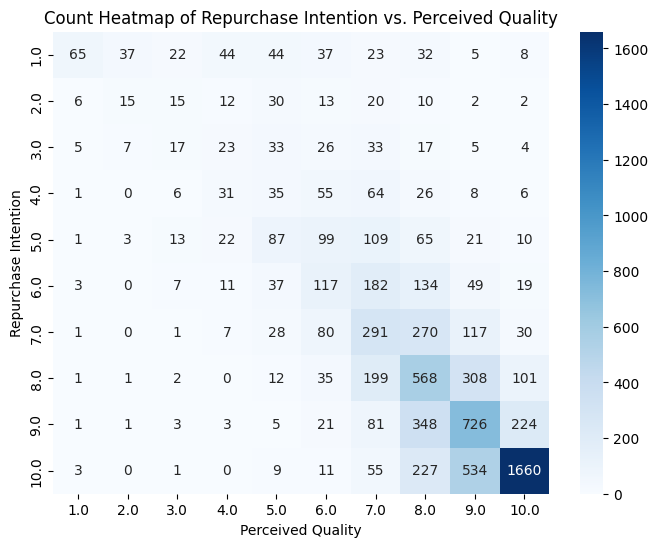

In [8]:
df_plot = df.loc[~df['overallq'].isin([98, 99]) & ~df['repur'].isin([98, 99])]

plt.figure(figsize=(8,6))
sns.heatmap(
    pd.crosstab(df_plot['repur'], df_plot['overallq']),
    annot=True, fmt="d", cmap="Blues"
)
plt.xlabel('Perceived Quality')
plt.ylabel('Repurchase Intention')
plt.title('Count Heatmap of Repurchase Intention vs. Perceived Quality')
plt.show()

## Clean Data

Keep only records for commercial banks to ensure comparability.

In [9]:
df = df[df['industry'] == 5001].reset_index()
print(f'Number of records remaining: {df.shape[0]:,}')

Number of records remaining: 2,505


Keep only columns of interest for ease of data processing.

In [10]:
df = df[[
    'overallq',
    'repur',
    'overallx',
    'pq',
    'satis',
    'comp'
]]
df.head(3)

,overallq,repur,overallx,pq,satis,comp
0,2.0,2.0,10.0,1.0,2,1.0
1,3.0,2.0,8.0,2.0,3,0.0
2,4.0,1.0,9.0,4.0,3,1.0


Replace values of 98 and 99 with NaN. Per the README, these values represent missing data.

In [11]:
df = df.replace([98, 99], np.nan)

Note that even after recoding the numeric placeholder values as NaN, the percent missing is small. We will assume data is missing completely at random (MCAR) and use complete case analysis by dropping any row that's missing a data value.

In [12]:
def missing_summary(df):
    missing_counts = df.isna().sum()
    missing_percent = round((missing_counts / len(df)) * 100,1)
    summary = pd.DataFrame({
        'missing_count': missing_counts,
        'missing_percent': missing_percent
    }).sort_values(by='missing_percent', ascending=False)
    return summary

missing_summary(df)

,missing_count,missing_percent
overallx,86,3.4
repur,70,2.8
pq,58,2.3
comp,34,1.4
overallq,20,0.8
satis,0,0.0


In [13]:
df = df.dropna()
print(f'Number of records remaining: {df.shape[0]:,}')

Number of records remaining: 2,307


Take a look at the distribution of the remaining data. Note that all features except complaints (comp, which is binary) are on a Likert scale from 1 to 10, with a high median of 8 or 9.

In [14]:
df.describe()

,overallq,repur,overallx,pq,satis,comp
count,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000
mean,8.408756,8.154746,8.423494,7.901604,8.144777,0.189857
std,1.667705,2.331555,1.521634,2.081666,1.901481,0.392273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.000000,7.000000,8.000000,7.000000,7.000000,0.000000
50%,9.000000,9.000000,9.000000,8.000000,9.000000,0.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


To make our estimate of the causal effect easier to interpret, we will convert all Likert scale features to binary.

In [15]:
likert_cols = [col for col in df.columns if df[col].min() == 1 and df[col].max() == 10]
for col in likert_cols:
    df[col] = (df[col] >= 9).astype(int)

df.describe()

,overallq,repur,overallx,pq,satis,comp
count,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000
mean,0.564369,0.593411,0.536194,0.472475,0.508453,0.189857
std,0.495947,0.491303,0.498796,0.499350,0.500037,0.392273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Define a Causal Model

Leverage the DoWhy CausalModel class to create a directed acyclic graph (DAG) that hypothesizes relationships between features. DoWhy uses DOT syntax (plain-text graph description language that comes with the software Graphviz) to define custom DAGs based on nodes and edges.

In [16]:
causal_graph = """
digraph {

    overallq -> pq;
    overallq -> satis;

    overallx -> overallq;
    overallx -> pq;
    overallx -> satis;

    pq -> satis;

    satis -> comp;
    satis -> repur;

    comp -> repur;
}
"""

model = CausalModel(
    data = df,
    treatment = 'overallq',
    outcome = 'repur',
    graph = causal_graph
)

Create a basic visualization of the graph to check that the nodes and edges are as expected.

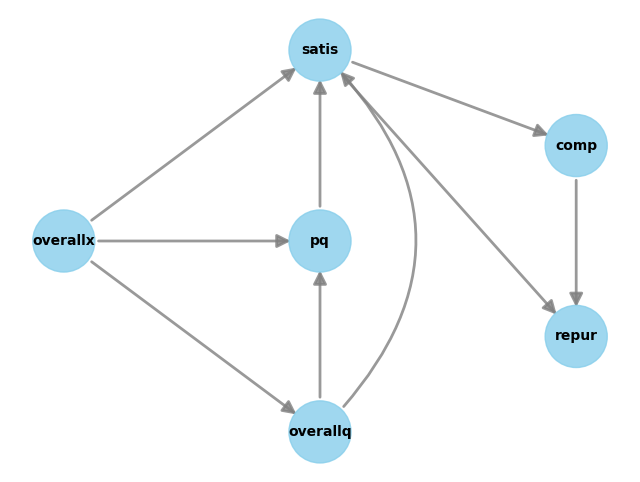

In [17]:
model.view_model()

## Identify Confounders for Adjustment

Here we identify the estimand, or the value that is going to be calculated when we estimate an effect. In this case, the defaul estimand is the nonparametric Average Treatment Effect (ATE). The ATE represents on average how much the outcome would change if everyone were treated compared to if no one were treated, taking confounders into consideration. Nonparametric means we are not assuming linearity or normality in how the primary predictor (perceived quality) affects the outcome (customer loyalty).

Based on the backdoor criteria, to estimate the causal effect (nonparametric ATE) of perceived product quality (overallq) on customer loyalty (repur) it is only necessary to control for customer expectation (overallx). Controlling for this one feature blocks all backdoor paths from product quality to customer loyalty allowing for identification of the effect. The rest of the features (pq, satis, and comp) are mediators.

In [18]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
───────────(E[repur|overallx])
d[overallq]                   
Estimand assumption 1, Unconfoundedness: If U→{overallq} and U→repur then P(repur|overallq,overallx,U) = P(repur|overallq,overallx)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                        
───────────(E[repur|overallx])
d[overallq]                   
Estimand assumption 1, Unconfoundedness: If U→{overallq} and U→repur then P(repur|overallq,overallx,U) = P(repur|overallq,overallx)



## Estimate the Causal Effect

There are various methods that we can use to calculate the value of the estimand identified above (nonparametric ATE, controlling for overallx). As a sensitivity analysis, we will estimate the causal effect using three methods:

- <b>backdoor.linear_regression:</b> adjusts for confounders using linear regression, which is likely inappropriate for our binary outcome.

- <b>backdoor.propensity_score_matching:</b> matches treatment and control records based on propensity scores.

- <b>backdoor.propensity_score_weighting:</b> weights units according to inverse propensity scores.

In [32]:
methods = [
    "backdoor.linear_regression",
    "backdoor.propensity_score_matching",
    "backdoor.propensity_score_weighting",
]

Looking at the results, we can see that linear regression and propensity score weighting give very similar results (ATE = 0.58) while propensity score matching identifies a larger effect (ATE = 0.71). This discrepancy is likely because matching estimates the effect based on a matched subset of treatment and control records, while the other methods use the entire population.

We will proceed using the results from propensity score weighting for several reasons: (1) it is more appropriate than linear regression for our binary outcome, (2) it provides an estimate based on the entire population, and (3) it is among the more conservative estimates.

In [33]:
results = []

for method in methods:
    causal_estimate = model.estimate_effect(
        estimand,
        method_name=method
    )
    results.append({
        "method": method,
        "causal_estimate": causal_estimate.value
    })

results_df = pd.DataFrame(results)
results_df

/Users/ellie/Documents/venvs/venv_250904/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


,method,causal_estimate
0,backdoor.linear_regression,0.581002
1,backdoor.propensity_score_matching,0.709146
2,backdoor.propensity_score_weighting,0.581487


To ensure that our results are robust, we will use refutation tests to confirm if this result holds under alternative scenarios. Specifically, we will run four types of tests:
- <b>

In [38]:
# 2. Estimate ATE using propensity score weighting
causal_estimate = model.estimate_effect(
    estimand,
    method_name="backdoor.propensity_score_weighting"
)

# Prepare a list to store results
results = []

# Add the main ATE estimate
results.append({
    "Refuter": "ATE (propensity_score_weighting)",
    "Estimated_Effect": causal_estimate.value,
    "Notes": "Main estimate"
})

# 3. Placebo treatment refuter
refute_placebo = model.refute_estimate(
    estimand,
    causal_estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"  # random permutation of treatment
)
results.append({
    "Refuter": "Placebo Treatment",
    "Estimated_Effect": refute_placebo.new_effect,
    "Notes": "Should be near 0 if estimate is robust"
})

# 4. Data subset refuter
refute_subset = model.refute_estimate(
    estimand,
    causal_estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8  # use 80% of data
)
results.append({
    "Refuter": "Data Subset",
    "Estimated_Effect": refute_subset.new_effect,
    "Notes": "Check robustness across subsets"
})

# 5. Random common cause refuter
refute_random_cause = model.refute_estimate(
    estimand,
    causal_estimate,
    method_name="random_common_cause"
)
results.append({
    "Refuter": "Random Common Cause",
    "Estimated_Effect": refute_random_cause.new_effect,
    "Notes": "Check sensitivity to weak hidden confounders"
})

# 6. Add unobserved common cause refuter
refute_unobserved = model.refute_estimate(
    estimand,
    causal_estimate,
    method_name="add_unobserved_common_cause",
)
results.append({
    "Refuter": "Add Unobserved Common Cause",
    "Estimated_Effect": refute_unobserved.new_effect,
    "Notes": "Check sensitivity to strong hidden confounders"
})

# 7. Convert to DataFrame for a clean summary
results_df = pd.DataFrame(results)

# Display the summary table
results_df

/Users/ellie/Documents/venvs/venv_250904/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ellie/Documents/venvs/venv_250904/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/ellie/Documents/venvs/venv_250904/lib/python3.12/site-packages/dowhy/causal_refuters/add_unobserved_common_cause.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

,Refuter,Estimated_Effect,Notes
0,ATE (propensity_score_weighting),0.581487,Main estimate
1,Placebo Treatment,-0.179423,Should be near 0 if estimate is robust
2,Data Subset,0.584657,Check robustness across subsets
3,Random Common Cause,0.581487,Check sensitivity to weak hidden confounders
4,Add Unobserved Common Cause,-0.115678,Check sensitivity to strong hidden confounders
